# SNODAS Wrapper

This code was written by Jonah Joughin with modifications by A. Arendt

We're aware of a few other repos that overlap with this work:

* David Hill's [matlab and shell scripts](https://github.com/dfosterhill/SNODAS)
* David Shean's [Python snowtools](https://github.com/dshean/snowtools)

### Aug 20, 2021

Working to update this, noting that some things require modification. For example, the Google Elevation API now costs money to use.

In [1]:
%matplotlib inline
import re
import os
import math
import xarray as xr
import numpy as np
import dask
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from validation import SNODAS, Elevation, utils as ut, creds
import mtnhubsnow as mh

## Downloading Data from SNODAS
Data can be fetched from SNODAS using the `snodas_ds(date)` function. It can then be saved using the appropriate function e.g. `save_netcdf(dataset, path)` or `save_tiff(dataset, path)`

Run this only one

In [ ]:
# Fetch data from SNODAS
start_date = datetime(2019,9,14)
for date in (start_date + timedelta(n) for n in range(180)):
    output_path = date.strftime('data/SNODAS/SNODAS_%Y%m%d.nc')
    print(output_path)
    if not os.path.exists(output_path):
        snodas_ds = SNODAS.snodas_ds(date)
        ut.save_netcdf(snodas_ds, output_path)

data/SNODAS/SNODAS_20190914.nc
data/SNODAS/SNODAS_20190915.nc
data/SNODAS/SNODAS_20190916.nc
data/SNODAS/SNODAS_20190917.nc
data/SNODAS/SNODAS_20190918.nc
data/SNODAS/SNODAS_20190919.nc
data/SNODAS/SNODAS_20190920.nc
data/SNODAS/SNODAS_20190921.nc
data/SNODAS/SNODAS_20190922.nc
data/SNODAS/SNODAS_20190923.nc
data/SNODAS/SNODAS_20190924.nc
data/SNODAS/SNODAS_20190925.nc
data/SNODAS/SNODAS_20190926.nc
data/SNODAS/SNODAS_20190927.nc
data/SNODAS/SNODAS_20190928.nc
data/SNODAS/SNODAS_20190929.nc
data/SNODAS/SNODAS_20190930.nc
data/SNODAS/SNODAS_20191001.nc
data/SNODAS/SNODAS_20191002.nc
data/SNODAS/SNODAS_20191003.nc
data/SNODAS/SNODAS_20191004.nc
data/SNODAS/SNODAS_20191005.nc
data/SNODAS/SNODAS_20191006.nc
data/SNODAS/SNODAS_20191007.nc
data/SNODAS/SNODAS_20191008.nc
data/SNODAS/SNODAS_20191009.nc
data/SNODAS/SNODAS_20191010.nc
data/SNODAS/SNODAS_20191011.nc
data/SNODAS/SNODAS_20191012.nc
data/SNODAS/SNODAS_20191013.nc
data/SNODAS/SNODAS_20191014.nc
data/SNODAS/SNODAS_20191015.nc
data/SNO

## Merging files into single NetCDF files
Merging together NetCDF files for different dates can be accomplished by reading those files into xarray, and then writing the resulting dataset out to a new NetCDF file. It is important to set the proper coordinates along the time axis of the dataset before writing, in order to record the date of each individual layer. 

In [2]:
output_path = 'data/SNODAS/SNODAS_2019_sample.nc'
# Only process if file does not already exist
if not os.path.exists(output_path):
    # Get list of valid files
    pattern = re.compile("^SNODAS_\d{8}.nc$")
    # There's something wrong with SNODAS-20170913 - only use files after this for now
    files = sorted([os.path.join("data/SNODAS",f) for f in os.listdir("data/SNODAS") if pattern.match(f)])
    # Extract dates from files
    dates = [ut.date_from_file(f) for f in files]

    ds = xr.open_mfdataset(files, concat_dim='time', combine='nested')
    ds.coords['time'] = dates

# Serializing is causing my local machine to crash - we should explore exporting to S3?
    #ds.to_netcdf(output_path)

In [3]:
ds

<xarray.Dataset>
Dimensions:  (time: 73, lat: 4096, lon: 8192)
Coordinates:
  * lat      (lat) float64 24.1 24.11 24.12 24.13 ... 58.2 58.21 58.22 58.23
  * lon      (lon) float64 -130.5 -130.5 -130.5 -130.5 ... -62.27 -62.26 -62.25
  * time     (time) datetime64[ns] 2019-09-14 2019-09-15 ... 2019-11-25
Data variables:
    Band1    (time, lat, lon) float32 dask.array<chunksize=(1, 4096, 8192), meta=np.ndarray>
    crs      (time) |S1 b'' b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b'' b''
Attributes:
    Conventions:  CF-1.5
    GDAL:         GDAL 3.0.2, released 2019/10/28
    history:      Fri Aug 13 14:56:42 2021: GDAL Create( data/SNODAS/SNODAS_2...

### MISSING MASKED FILES

These notes are from David Hill's [shell script](https://github.com/dfosterhill/SNODAS/blob/master/get_proc_snodas.sh)

### The following dates are missing ALL data (YYYY-MM-DD):

* 2004-02-25
* 2004-08-31
* 2004-09-27
* 2005-06-25
* 2005-08-01
* 2005-08-02
* 2006-08-26
* 2006-08-27
* 2006-09-08
* 2006-09-30
* 2006-10-01
* 2007-02-14
* 2007-03-26
* 2008-03-13
* 2008-06-13
* 2008-06-18
* 2009-08-20
* 2012-12-20

### The following dates are missing individual files:

2003-10-30 is missing one file:

* us_ssmv11034tS__T0001TTNATS2003103005HP001

## Loading Merged Data in XArray
The merged dataset can then be reimported to xarray with the following function. The merging process is important, as it allows xarray to search the dataset much faster, opening up the possibility of API queries.

In [ ]:
ds = xr.open_dataset('data/SNODAS/SNODAS_2019_example.nc')

## Selecting snow depth across region
Data can be selected in a particular region by using the `sel` and `isel` functions in conjunction with `slice`, as shown below.

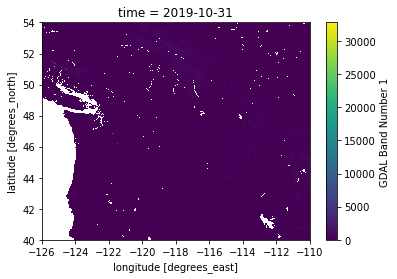

In [4]:
ds.Band1.sel(time = '2019-10-31', lat = slice(40, 54), lon = slice(-126, -110)).plot()

## Selecting time series at location
A time series can be constructed as follows. It is important that the method parameter is set to `'nearest'` in order to recieve results.

In [17]:
region = {
    'latmax' : 44.25,
    'latmin' : 43.75,
    'lonmax': -121.65,
    'lonmin': -122.5,
}

In [18]:
obs = mh.snow_data(limit=10000000, start=datetime(2019,11,9), bbox=region)

In [13]:
# The Google Elevation API now costs $$ to use

# We should depreciate the Elevation.py script

#obs = Elevation.merge_el_data(obs)
#plot = obs.plot(x='date', y='snow_depth', style='o')
#snodas_series = ds.Band1.sel(lat=lat, lon=-122, method='nearest') / 10
#snodas_series.plot(ax=plot)


## Plotting Data Against SNODAS

This is older code that needs to be updated

In [ ]:
# Restrict points to the continental US
region = {
    'ymax' : 50,
    'ymin' : 25,
    'xmax': -65,
    'xmin': -125,
}

obs = MountainHub.snow_data(limit=1000, start=datetime(2017,9,14), end=datetime(2018,3,28), box=region)
def snodas_depth(ts, lon, lat):
    height = ds.Band1.sel(time = ts.strftime('%Y-%m-%d'), lon=lon, lat=lat, method='nearest').item()
    if not np.isnan(height):
        height /= 10
    return height

obs['snodas_depth'] = obs.apply(lambda x: snodas_depth(x['date'], x['long'], x['lat']), axis=1)

sns.set(color_codes=True)
sns.lmplot(x='snodas_depth',y='snow_depth',data=obs, fit_reg=True, lowess=True) 